In [2]:
%load_ext autoreload
%autoreload 2


import Functions.Feflow_Utils as FU
import Functions.Observation_Weighting as OW
import Functions.Ensemble_Assimilation as EA
import Functions.Import_Saltflow as IS
import Functions.Import_Data as ID

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from subprocess import call


## Defining the observation weight around each observation point 

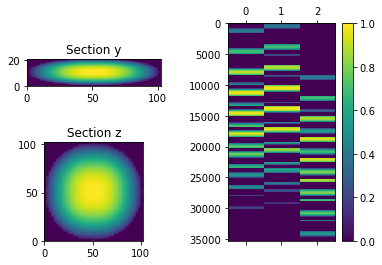

In [2]:
""" ------ Definition of ellipsoid search ------ """

max_range = 50
med_range = 50
min_range = 10
azimuth = 0 * np.pi/180
dip = 0 * np.pi/180

""" ------ Definition of grid parameters ------ """

x_step = 2.5
y_step = 2.5
z_step = 1
nx = 41
ny = 41
nz = 21

""" ------ Creation of the object Observation_Weight ------ """

Object_Observation_Weight = OW.Observation_Weight(nx,
                            ny,
                            nz,
                            x_step,
                            y_step,
                            z_step,
                            max_range,
                            med_range,
                            min_range,
                            azimuth,
                            dip)

""" Unique ellipsoid for all the observed points here """

local_index, local_var = OW.clean_ellipse_index(Object_Observation_Weight.local_index_, Object_Observation_Weight.local_var_)

""" ------ Definition of the observation points ------ """


well0 = Object_Observation_Weight.ellispoid_around_index( 22, 30, 8, local_index, local_var)
well1 = Object_Observation_Weight.ellispoid_around_index(30, 10, 8, local_index, local_var)
well2 = Object_Observation_Weight.ellispoid_around_index(10, 9, 13, local_index, local_var)



""" ------ Saving of the observation points ------ """

f = open("Data/weights_well_0.txt",'w')
temp = np.nonzero(well0)[0][:]
for i in temp :
    f.write(str(i)+","+str(well0[i][0])+"\n")
f.close()

f = open("Data/weights_well_1.txt",'w')
temp = np.nonzero(well1)[0][:]
for i in temp :
    f.write(str(i)+","+str(well1[i][0])+"\n")
f.close()

f = open("Data/weights_well_2.txt",'w')
temp = np.nonzero(well2)[0][:]
for i in temp :
    f.write(str(i)+","+str(well2[i][0])+"\n")
f.close()


""" ------ Visual quality check of the observation points ------ """

if True :
    localisation = np.hstack((well0,well1,well2))


    plt.subplot(221)
    i = int(Object_Observation_Weight.get_range()[1]/2)
    plt.imshow(Object_Observation_Weight.local_ellipse_value_.reshape(Object_Observation_Weight.get_range())[:,i,:], extent=[0,nx*x_step,0,nz*z_step])
    plt.title("Section y")

    i = int(Object_Observation_Weight.get_range()[0]/2)
    plt.subplot(223)
    plt.imshow(Object_Observation_Weight.local_ellipse_value_.reshape(Object_Observation_Weight.get_range())[i,:,:], extent=[0,nx*x_step,0,ny*y_step])
    plt.title("Section z")


    plt.subplot(122)
    plt.matshow(localisation,aspect='auto',fignum=False)
    plt.colorbar()
    plt.subplots_adjust(wspace = 0.5)
    plt.show()


## Loading the measures thanks to the ID library

In [3]:
path = "D:/Dropbox/Doctorat_INRS-master/Doctorat_INRS/Doctorat_INRS/"

wells = 5
ensemble_number = 90
cells_3d_model = 35301

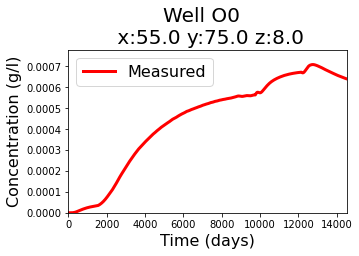

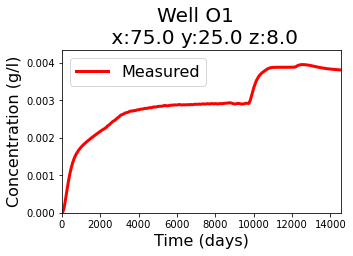

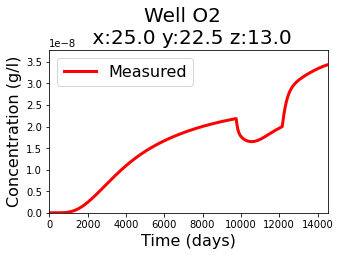

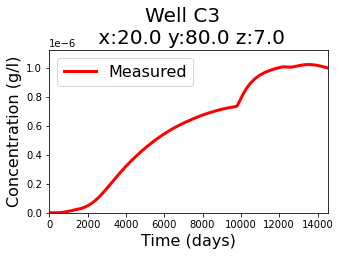

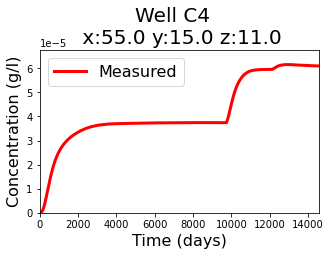

In [4]:
measured = ID.Measures("Data/measures.txt")
for i in range(measured.nbr_obs_points_):
    measured.wells_[i].plot()

## Multiple Data assimilation process

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

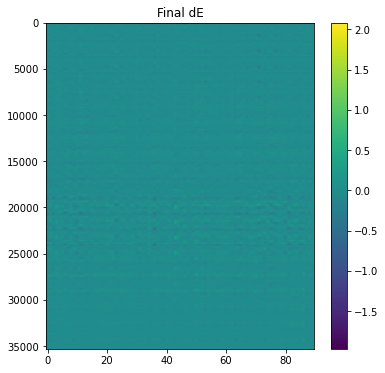

100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [4:01:38<00:00, 14498.81s/it]


In [5]:
IS.load_results(1, "D:/Dropbox/Doctorat_INRS-master/Doctorat_INRS/Doctorat_INRS/", False)
    
for i in tqdm(range(4,5)):
    
    observations = ID.Observation("Data/observed_"+str(i)+".txt")
    
    
    # Condition to display the concentration of a given model in the simulation ensemble
    if False :
        # A number of model is needed, not possible to plot the concentration for all simulation 

        model_ = 42
        for i in range(observations.nbr_obs_points_):
            observations.wells_[i][model_].plot()
            
            
    """
    In this example : 
    
    observed_1 and reference -> k_fields_update_1
    observed_2 and k_fields_update_1 -> k_fields_update_2
    observed_3 and k_fields_update_2 -> k_fields_update_3
    observed_4 and k_fields_update_3 -> k_fields_update_4
    
    """
    
    
    if i == 1 :
        filename='Data/Reference/k_fields/fgen92_sim'
    else :
        filename='Data/k_fields_update_'+str(int(i-1))+'/fgen92_sim'
        

    ensemble_matrix = ID.import_permeability_field(filename,ensemble_number, cells_3d_model)
    
    
    # Looping on all observations to compute update with location
    
    
    dE_well = np.zeros(( 3, cells_3d_model, ensemble_number ))


    for k in range(3):
        # We have to concatenate well data into one 1D vector data for assimilation purpose
        # First loop to determine the total amount of data point, can vary from one project to another one

        well_observed_number = k

        # min_ and max_ are the percent of data to be retained for assimilation purpose
        min_ = 0.6
        max_ = 0.87

        number_of_obs = int(max_*measured.wells_[well_observed_number].size_) \
            -int(min_*measured.wells_[well_observed_number].size_)

        # Import model number associated with the well well_observed_number


        cpk_measurement = measured.wells_[well_observed_number].get_well_data()[1][
            int(measured.wells_[well_observed_number].size_ * min_):\
            int(measured.wells_[well_observed_number].size_ * max_)]

        cpk_observed = np.zeros(( ensemble_number, number_of_obs ))

        for j in range(ensemble_number):
            cpk_observed[j] = observations.wells_[well_observed_number][j].get_well_data()[1][
            int(measured.wells_[well_observed_number].size_*min_):\
            int(measured.wells_[well_observed_number].size_*max_)]


        # Assimilation process

        percent_error = 0.005

        test = EA.EnsembleKalmanFilter_Emerick(ensemble_matrix, 
                           cpk_measurement,
                           cpk_observed.T,                 
                           percent_error,
                           4,
                           False)

        test.analysis_step()

        """
        for j in range(ensemble_number):
            plt.plot(np.asarray(test.D_.T[j])[0])
        plt.show()
        """
        dE_well[k] = test.dE
    
    
    # Computing weighted update

    damping_weight_KG = np.loadtxt("Data/weights_well_0.txt",delimiter=',').T
    damping_weight_KG_1 = np.loadtxt("Data/weights_well_1.txt",delimiter=',').T
    damping_weight_KG_2 = np.loadtxt("Data/weights_well_2.txt",delimiter=',').T


    weighting_index = {}

    for j in range(len(damping_weight_KG[0])) :
        weighting_index[int(damping_weight_KG[0][j])] = [damping_weight_KG[1][j], 0, 0]


    for j in range(len(damping_weight_KG_1[0])) :
        if int(damping_weight_KG_1[0][j]) in weighting_index :
            weighting_index[int(damping_weight_KG_1[0][j])][1] = damping_weight_KG_1[1][j]
        else :
            weighting_index[int(damping_weight_KG_1[0][j])] = [0, damping_weight_KG_1[1][j], 0]

    for j in range(len(damping_weight_KG_2[0])) :
        if int(damping_weight_KG_2[0][j]) in weighting_index :
            weighting_index[int(damping_weight_KG_2[0][j])][2] = damping_weight_KG_2[1][j]
        else :
            weighting_index[int(damping_weight_KG_2[0][j])] = [0, 0, damping_weight_KG_2[1][j]]

    final_dE =  np.zeros(( cells_3d_model, ensemble_number ))


    for x in weighting_index:

        final_dE[x] = (dE_well[0][x]*weighting_index[x][0] + \
                     dE_well[1][x]*weighting_index[x][1] + \
                     dE_well[2][x]*weighting_index[x][2] ) / \
                     np.sum(weighting_index[x])


    plt.figure(figsize=(6,6))
    plt.imshow(final_dE,aspect='auto')
    plt.colorbar()
    plt.title('Final dE')
    plt.show()


    final_assim = ensemble_matrix + final_dE


    new_k_ensemble = np.zeros((ensemble_number,cells_3d_model))
    
    
    for iter_ in range(ensemble_number): 

        temp_file = open('Data/k_fields_update_'+str(i)+'/fgen92_sim'+str(iter_)+'.asc','w') 
        temp_file.write('          realization #    '+str(iter_)+'\n')
        temp_file.write('  41    41   21     2.5     2.5     1.0  \n')
        for line in range(cells_3d_model):
            temp_file.write(str(round(final_assim[line,iter_],4))+'\n')
        temp_file.close()
            
            
            
    f =  open("temp_saltflow/folder.txt", "w")
    f.write("Data/k_fields_update_"+str(i)+"\n")
    f.write("Data/break_update_"+str(int(i+1)))
    f.close()
    
    
    """
    
    / ! \     Update the path in the temp_saltflow/launch_saltflow.py   
    
    
    """
    
    # Simulation
    
    call(["python", "D:/Dropbox/Doctorat_INRS-master/Doctorat_INRS/Doctorat_INRS/temp_saltflow/launch_saltflow.py"])
    
    
    # Creating observed file for the next assimilation
    IS.load_results(i+1, "D:/Dropbox/Doctorat_INRS-master/Doctorat_INRS/Doctorat_INRS/", False)
    
            

In [3]:
IS.load_results(5, "D:/Dropbox/Doctorat_INRS-master/Doctorat_INRS/Doctorat_INRS/", False)